---
title: "From Continuous Flows to Score Matching"
author: "Mark Fuge"
date: "November 9th, 2025"
format:
    html:
        code-fold: true
        code-summary: "Show Code"
---

In the previous chapter, we explored Continuous Normalizing Flows (CNFs), where we learned a vector field $v_t$ to transform a simple base distribution into a complex data distribution. The training objective involved maximizing the log-likelihood of the data, which required computing the trace of the Jacobian of the vector field:

$$
\log p_1(x) = \log p_0(z) - \int_0^1 \text{Tr}\left(\nabla_x v_t(x(t))\right) dt
$$

While powerful, this approach has a significant computational bottleneck: the trace term $\text{Tr}(\nabla_x v_t)$. For high-dimensional data like images, computing this trace is prohibitively expensive, often requiring clever estimation tricks or restrictive model architectures that can slow down training.

This raises a critical question: **Can we define and train a generative model based on a vector field without ever needing to compute a trace?**

This chapter introduces **Score Matching**, a powerful alternative that achieves exactly this.

## Learning Objectives

By the end of this notebook, you should be able to:

-   Explain the computational bottleneck of Continuous Normalizing Flows.
-   Define the **score function** and its relationship to the data distribution.
-   Describe how the score function can be used for generative sampling.
-   Understand the challenge of learning the score function directly.
-   Explain how **Denoising Score Matching (DSM)** provides a practical, trace-free objective for learning the score.
-   Implement a simple score-based model and use it for generative sampling with Langevin dynamics.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import torch
from torch import nn
import torch.optim as optim
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from gen_models_utilities import create_ring_gaussians, make_loader

# Use a consistent style
plt.style.use('seaborn-v0_8-muted')
sns.set_context('talk')

# for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

device = "cpu"
print(f'Using device: {device}')

Using device: cpu


## Sampling by "Climbing" the Probability Landscape

Imagine our data distribution $p_{data}(x)$ as a "probability landscape"—a mountain range where peaks correspond to likely data points (e.g., realistic images) and valleys represent unlikely ones (e.g., noise). If we were placed randomly in this landscape, how could we find (aka, generate) a "good" data point? A natural strategy would be to climb uphill. We saw this idea previously in the context of MCMC sampling, for example where Hamiltonian Monte Carlo (HMC) uses gradients to propose moves towards higher probability regions. Likewise, we will use similar ideas in Score Matching to define a generative process. Specifically, the direction of steepest ascent on the log-probability landscape is given by its gradient. This leads us to the definition of the **score function**.

### The Score Function

The score function is the gradient of the log-probability density with respect to the data $x$:

$$
s(x) \equiv \nabla_x \log p(x)
$$

This function defines a vector field where every vector points "uphill" towards the nearest mode (peak) of the data distribution. If we could learn this vector field, we could invent a new generative process:

1.  Start from a random point $x_0$.
2.  Follow the score vectors to "climb" the landscape.
3.  Arrive at a peak, which corresponds to a high-likelihood data sample.


## The First Hurdle: How to Learn the Score?

Let's imagine that we want to train a neural network $s_\theta(x)$ to approximate the true data score $s_{p_{data}}(x)$. The most straightforward objective is to minimize the L2 distance between our model's score and the true score, an objective known as the **Fisher Divergence**:

$$
J(\theta) = \mathbb{E}_{x \sim p_{data}(x)} \left[ \| s_{p_{data}}(x) - s_\theta(x) \|^2 \right]
$$

However, this objective is intractable. To compute it, we need the true data score $s_{p_{data}}(x) = \nabla_x \log p_{data}(x)$. But we don't know the underlying data distribution $p_{data}(x)$; we only have samples from it. This is the central challenge of score matching.

## Solution 1: Hyvärinen's Score Matching

In 2005, Aapo Hyvärinen used techniques from partial integration to prove that the intractable Fisher Divergence objective is equivalent to a tractable one, under certain regularity conditions. The key result is:

$$
J(\theta) \propto \mathbb{E}_{x \sim p_{data}(x)} \left[ \text{Tr}\left(\nabla_x s_\theta(x)\right) + \frac{1}{2} \| s_\theta(x) \|^2 \right]
$$

What his result allowed is for us to eliminate the need for the unknown true score $s_{p_{data}}(x)$, allowing us to compute an objective using only our model $s_\theta$ and data samples $x \sim p_{data}(x)$, which we have (this is our training data).

However, look closely at the first term: $\text{Tr}(\nabla_x s_\theta(x))$[^1]. We are right back where we started with continuous flow matching. We've traded one generative model (CNF) for another (Score Matching), but we are still stuck with the same computationally expensive trace of the Jacobian. This is why classic Score Matching wasn't a silver bullet for high-dimensional cases where CNFs struggled.

[^1]: Note that in some texts this is referred to as $\nabla \cdot s_\theta(x)$ (the divergence of the score function) instead of $\text{Tr}(\nabla_x s_\theta(x))$, but these are mathematically equivalent.

## Solution 2: Denoising Score Matching (DSM)

The breakthrough came in 2011 from Pascal Vincent, who asked: **What if we try to learn the score of *noisy* data instead of clean data?**

To see what we might mean by this, consider the following setup:

1.  **Define a noise kernel**: We perturb our data $x$ with Gaussian noise: $p_\sigma(\tilde{x} | x) = \mathcal{N}(\tilde{x} | x, \sigma^2 I)$.
2.  **Create a noisy data distribution**: This process defines a new, noisy data distribution $p_\sigma(\tilde{x}) = \int p_\sigma(\tilde{x} | x) p_{data}(x) dx$.
3.  **Set a new goal**: Our goal is now to learn the score of this noisy distribution: $s_\theta(\tilde{x}) \approx \nabla_{\tilde{x}} \log p_\sigma(\tilde{x})$.

It turns out that the objective for this new problem, $\mathbb{E}_{p_\sigma(\tilde{x})} [\| \nabla_{\tilde{x}} \log p_\sigma(\tilde{x}) - s_\theta(\tilde{x}) \|^2]$, also simplifies, but to something much better. The optimal score model $s_\theta(\tilde{x})$, which is the thing we are trying to learn, for the Denoising objective is the one that minimizes:

$$
J_\sigma(\theta) = \mathbb{E}_{x \sim p_{data}, \tilde{x} \sim p_\sigma(\cdot|x)} \left[ \left\| s_\theta(\tilde{x}) - \nabla_{\tilde{x}} \log p_\sigma(\tilde{x} | x) \right\|^2 \right]
$$

This new target, $\nabla_{\tilde{x}} \log p_\sigma(\tilde{x} | x)$, is the score of our noise kernel, which we know analytically. Since the log-probability of our Gaussian noise kernel is:

$$
\log p_\sigma(\tilde{x} | x) = C - \frac{1}{2\sigma^2} \|\tilde{x} - x\|^2
$$

its gradient with respect to $\tilde{x}$ is simply:

$$
\nabla_{\tilde{x}} \log p_\sigma(\tilde{x} | x) = -\frac{\tilde{x} - x}{\sigma^2}
$$

We can substitute this back into our original objective:
$$
J_\sigma(\theta) = \mathbb{E}_{x \sim p_{data}, \tilde{x} \sim p_\sigma(\cdot|x)} \left[ \left\| s_\theta(\tilde{x}) + \frac{\tilde{x} - x}{\sigma^2} \right\|^2 \right]
$$

And rename $\tilde{x}$ as $x + \epsilon$, where $\epsilon \sim \mathcal{N}(0, \sigma^2 I)$, to arrive at the final form:
$$
J_\sigma(\theta) = \mathbb{E}_{x \sim p_{data}, \epsilon \sim \mathcal{N}(0, \sigma^2 I)} \left[ \left\| s_\theta(x + \epsilon) + \frac{\epsilon}{\sigma^2} \right\|^2 \right]
$$  

This gives us our final, practical, **trace-free** Denoising Score Matching (DSM) loss:

$$
J_\sigma(\theta) = \mathbb{E}_{x \sim p_{data}, \epsilon \sim \mathcal{N}(0, \sigma^2 I)} \left[ \left\| s_\theta(x + \epsilon) + \frac{\epsilon}{\sigma^2} \right\|^2 \right]
$$

This is just a simple L2 regression! We train a neural network to:
1. Take a noisy sample $\tilde{x} = x + \epsilon$.
2. Predict the "ground truth" score, which is proportional to the noise that was added: $-\epsilon / \sigma^2$.

There is no trace and no intractable integrals. We have successfully found a way to learn a generative vector field that completely bypasses the CNF bottleneck. To enable this, we had to assume that we were okay with learning the score of a noisy version of the data distribution, which may seem a bit silly but, as we will see in the next chapter, this turns out to be a powerful and flexible approach for generative modeling.

## Example: Learning a Score Model for a 2D Ring of Gaussians

Let's apply this to a 2D problem to build some intuition. We'll generate data from the Ring of Gaussians we have been using in earlier chapters, and then train a neural network to learn its score function $s_\theta$ using the DSM objective. This will allow us to visualize the learned score as a vector field.

In [2]:
#| code-fold: false
#### Try changing the noise level sigma here and see
# how it affects the learned score function.
# Try values like 0.01, 0.1, 0.5, 5.0
sigma = 0.1  # Noise level
#####################3

# Create the dataset
data, _ = create_ring_gaussians(n_samples=5000)
loader = make_loader(data, batch_size=256)

# Define the neural network to model the score function s_theta(x)
class ScoreNet2D(nn.Module):
    def __init__(self, hidden=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hidden),
            nn.Softplus(),
            nn.Linear(hidden, hidden),
            nn.Softplus(),
            nn.Linear(hidden, 2)
        )

    def forward(self, x):
        return self.net(x)

# Training parameters
lr = 1e-3
n_epochs = 400

# Model and optimizer
score_net = ScoreNet2D().to(device)
optimizer = optim.AdamW(score_net.parameters(), lr=lr)

# Training loop
for epoch in range(n_epochs):
    for (x,) in loader:
        x = x.to(device)
        
        # 1. Add noise
        noise = torch.randn_like(x) * sigma
        x_tilde = x + noise
        
        # 2. Predict the score
        predicted_score = score_net(x_tilde)
        
        # 3. Compute the ground truth score (target)
        target_score = -noise / (sigma**2)
        
        # 4. Calculate the DSM loss
        loss = ((predicted_score - target_score)**2).mean()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

print("Training complete.")

Epoch 0, Loss: 99.9621
Epoch 20, Loss: 94.5389
Epoch 40, Loss: 96.6329
Epoch 60, Loss: 94.0892
Epoch 80, Loss: 95.9352
Epoch 100, Loss: 89.9783
Epoch 120, Loss: 91.1169
Epoch 140, Loss: 91.3176
Epoch 160, Loss: 89.9263
Epoch 180, Loss: 81.9100
Epoch 200, Loss: 96.8376
Epoch 220, Loss: 91.9254
Epoch 240, Loss: 82.5780
Epoch 260, Loss: 89.1135
Epoch 280, Loss: 78.5972
Epoch 300, Loss: 89.9539
Epoch 320, Loss: 88.9281
Epoch 340, Loss: 90.0029
Epoch 360, Loss: 81.8739
Epoch 380, Loss: 78.4657
Training complete.


Now let's visualize the learned score function as a vector field. We will overlay the score vectors on a contour plot of the target data distribution. This will show us the direction that the learned score function will push particles in.

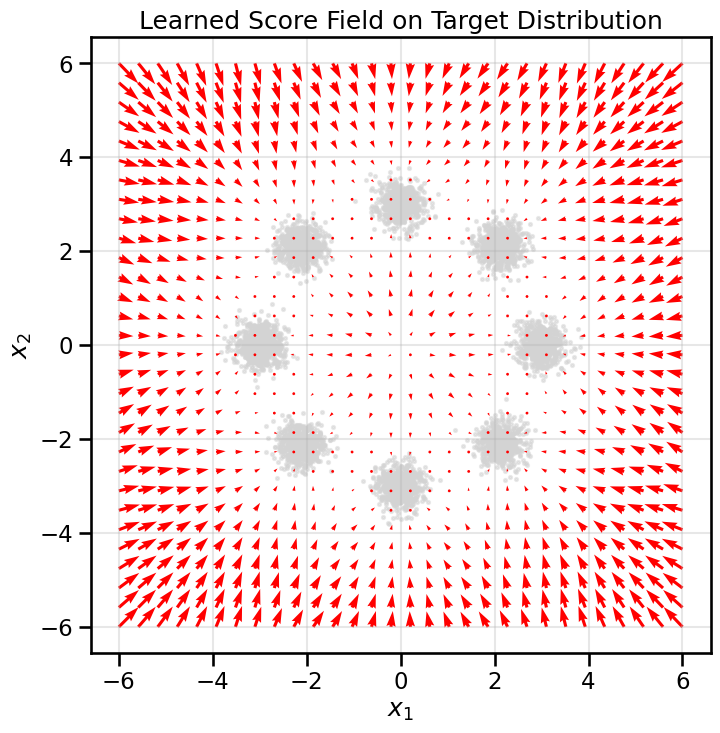

In [ ]:
# Create a grid to visualize the score field
xx, yy = np.meshgrid(np.linspace(-6, 6, 30), np.linspace(-6, 6, 30))
grid_points = torch.tensor(np.stack([xx.ravel(), yy.ravel()], axis=1), dtype=torch.float32, device=device)

# Get the score at each grid point
score_net.eval()
with torch.no_grad():
    scores = score_net(grid_points).cpu().numpy()

# Plot the results
plt.figure(figsize=(8, 8))
# Plot the data distribution as a contour plot -- this can be expensive, so I'll comment it out for now
#sns.kdeplot(x=data[:, 0], y=data[:, 1], cmap="viridis", fill=True, alpha=0.7)
# Plot the original data samples as light grey dots
plt.scatter(data[:, 0], data[:, 1], s=5, color='lightgrey', alpha=0.5)


# Plot the score field
plt.quiver(grid_points[:, 0].cpu(), grid_points[:, 1].cpu(), scores[:, 0], scores[:, 1], color='red', width=0.005)
plt.title('Learned Score Field on Target Distribution')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.show()

In [4]:
# Animation: Vector field as training progresses (DSM)
# We can set a separate sigma here for the animation
sigma_anim = sigma

# Fresh model for animation so we can see learning from scratch
score_net_anim = ScoreNet2D().to(device)
optimizer_anim = optim.AdamW(score_net_anim.parameters(), lr=1e-3)

# Grid for vector field
x_min, x_max, n_grid = -6.0, 6.0, 25
xx, yy = np.meshgrid(np.linspace(x_min, x_max, n_grid), np.linspace(x_min, x_max, n_grid))
grid_points = torch.tensor(np.stack([xx.ravel(), yy.ravel()], axis=1), dtype=torch.float32, device=device)

# Precompute background once
fig, ax = plt.subplots(figsize=(7, 7))
#sns.kdeplot(x=data[:, 0], y=data[:, 1], cmap="viridis", fill=True, alpha=0.4, ax=ax)
ax.scatter(data[:, 0], data[:, 1], s=5, color='lightgrey', alpha=0.5)
ax.set_xlim(x_min, x_max)
ax.set_ylim(x_min, x_max)
ax.set_aspect('equal', adjustable='box')
ax.grid(True, alpha=0.2)
ax.set_title('Training the Score Field (DSM)')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

# Initialize quiver (will update U,V each frame)
init_scores = np.zeros_like(grid_points.cpu().numpy())
# Scale down the arrows by a factor for better visibility:
Q = ax.quiver(grid_points[:, 0].cpu(), grid_points[:, 1].cpu(), 
              init_scores[:, 0], init_scores[:, 1],
              color='red', width=0.005, alpha=0.9)


# Training/animation parameters
n_epochs_anim = 400
capture_every = 10  # capture frame every N epochs
frames_UV = []
frame_labels = []

# Collect frames while training
print("Training for animation…")
for epoch in range(1, n_epochs_anim + 1):
    for (x_batch,) in loader:
        x = x_batch.to(device)
        noise = torch.randn_like(x) * sigma_anim
        x_tilde = x + noise

        pred = score_net_anim(x_tilde)
        target = -noise / (sigma_anim ** 2)
        loss = ((pred - target) ** 2).mean()

        optimizer_anim.zero_grad()
        loss.backward()
        optimizer_anim.step()

    if epoch % capture_every == 0 or epoch == 1:
        score_net_anim.eval()
        with torch.no_grad():
            S = score_net_anim(grid_points).cpu().numpy()
        # Rescale S so that the largest arrows is length 1.0
        max_len = np.max(np.linalg.norm(S, axis=1))
        if max_len > 0:
            S = S / max_len
        frames_UV.append(S)
        frame_labels.append(f"epoch {epoch} | loss {loss.item():.3f}")
        score_net_anim.train()
        
        # Optional console progress
        if epoch % (capture_every * 5) == 0 or epoch in (1, n_epochs_anim):
            print(frame_labels[-1])

# Build animation by updating quiver U,V

def init_anim():
    Q.set_UVC(init_scores[:, 0], init_scores[:, 1])
    return (Q,)

def update_anim(i):
    U = frames_UV[i][:, 0]
    V = frames_UV[i][:, 1]
    Q.set_UVC(U, V)
    ax.set_title(f'Training the Score Field (DSM) — {frame_labels[i]}')
    return (Q,)

ani = FuncAnimation(fig, update_anim, frames=len(frames_UV), init_func=init_anim,
                    blit=False, interval=100, repeat=False)
plt.close(fig)  # avoid static duplicate
HTML(ani.to_jshtml())

Training for animation…
epoch 1 | loss 103.260
epoch 50 | loss 97.533
epoch 100 | loss 98.608
epoch 150 | loss 88.190
epoch 200 | loss 88.734
epoch 250 | loss 83.404
epoch 300 | loss 80.596
epoch 350 | loss 78.519
epoch 400 | loss 90.604


The plot shows that our network has successfully learned the score function. The learned score vectors point away from the low-density region and towards the peaks of each Gaussian, just as expected.

::: {.callout-tip appearance="default"}
### Experiment: Effect of Noise Level on Denoising Score Matching

We saw above that the key trick in Denoising Score Matching is to add noise to the data before learning the score function. The amount of noise added is controlled by the parameter $\sigma$. But what effect does the choice of $\sigma$ have on the learned score function and the quality of generated samples?

- Try changing the noise level $\sigma$ to different values (e.g., 0.01, 0.1, 0.5, 5.0). How does this affect the learned score function?
- Reflect on how Denoising Score Matching achieves its approximation compared to the original score matching objective. What effect does the noise level have on this approximation? How is this reflected in the learned score function as you vary $\sigma$? 

:::

## How do we use the learned Score Function?

Now that we have a trained model $s_\theta(x)$ that can estimate the score of a data distribution, we can finally implement our "sampling by climbing" idea. 

A naive approach would be to start from random noise and iteratively update the sample by taking small steps in the direction of the score:
$$
x_{k+1} \leftarrow x_k + \alpha s_\theta(x_k)
$$

This is just gradient ascent on the log-probability landscape defined by our score model. However, this approach has a critical flaw: it will quickly get stuck in the nearest local maximum (peak) of the distribution and fail to explore the full data distribution. So while this is OK for optimization or finding modes of the distribution, it is not sufficient for generative sampling.

Instead, we need to introduce some randomness into the process to allow exploration of the landscape. This is done using **Langevin Dynamics** which involves taking a small step in the direction of the score (the gradient ascent "climb") and then adding a small amount of noise. This noise prevents the sampler from just finding the nearest peak and stopping; instead, it allows it to explore the full distribution.

The update rule for Langevin Dynamics is:
$$
x_{k+1} \leftarrow x_k + \alpha s_\theta(x_k) + \sqrt{2\alpha} z_k
$$

where $\alpha$ is the step size and $z_k \sim \mathcal{N}(0, I)$ is standard Gaussian noise. The $s_\theta(x_k)$ term performs the climb, while the $z_k$ term makes the process stochastic, turning it into a sampler (like MCMC) rather than just an optimizer.

The choice of step size $\alpha$ is important: too large and the sampler will be unstable, too small and it will mix slowly. In practice, $\alpha$ is often decreased over time (as we will see later) to allow for finer exploration as the sampler approaches high-density regions.

It perhaps seems magical that this simple procedure will converge to samples from the data distribution. The theoretical justification comes from the fact that Langevin Dynamics is a discretization of a continuous-time stochastic differential equation (SDE) whose stationary distribution is exactly the target distribution defined by the score function. Thus, as the number of steps goes to infinity and the step size goes to zero, the samples generated by Langevin Dynamics converge to samples from the target distribution.

Specifically, the SDE is given by:
$$
dx_t = s_\theta(x_t) dt + \sqrt{2} dW_t
$$
where $W_t$ is standard Brownian motion. We will see this connection to SDEs in more detail in the next chapter when we see its connection to Diffusion Models.


In [5]:
#| code-fold: false
# Compare deterministic gradient-ascent (no noise) vs Langevin dynamics (with noise)

def deterministic_ascent(score_model, init_points, steps=200, alpha=0.05):
    """Move points by x <- x + alpha * score(x) without noise and record trajectories."""
    x = init_points.clone().to(device)
    traj = [x.cpu().numpy()]
    score_model.eval()
    with torch.no_grad():
        for _ in range(steps):
            s = score_model(x)
            x = x + alpha * s
            traj.append(x.cpu().numpy())
    return np.array(traj)

# Langevin Dynamics Sampler for 2D
def langevin_sampler_2d(score_model, n_samples=500, n_steps=200, alpha=0.01, initial_noise_scale=5.0, track_trajectories=False, tracked_points=None):
    """Generate samples using Langevin Dynamics, with optional trajectory tracking."""
    if track_trajectories and tracked_points is not None:
        x = tracked_points.to(device)
        n_samples = tracked_points.shape[0]
    else:
        x = torch.randn(n_samples, 2, device=device) * initial_noise_scale
    
    trajectory = [x.cpu().detach().numpy()]
    
    score_model.eval()
    with torch.no_grad():
        for _ in range(n_steps):
            score = score_model(x)
            noise = torch.randn_like(x) * np.sqrt(2 * alpha)
            x = x + alpha * score + noise
            trajectory.append(x.cpu().detach().numpy())
            
    return x, np.array(trajectory)

# Choose three representative initial points (same as earlier examples)
init_points = torch.tensor([[ -1.0, -1.0], [ 0.0, 1.5], [ 1.0, -0.5]], dtype=torch.float32)

# Deterministic ascent trajectories (no noise)
det_traj = deterministic_ascent(score_net, init_points, steps=200, alpha=0.05)

# Langevin trajectories (with noise) using the sampler we defined earlier
_, lang_traj = langevin_sampler_2d(score_net, track_trajectories=True, 
                                   tracked_points=init_points, n_steps=200, alpha=0.01)

# Generate a larger set of samples for density comparison
generated_samples, _ = langevin_sampler_2d(score_net, n_samples=1000, alpha=0.01)


C:\Users\mafuge\AppData\Local\Temp\ipykernel_14996\2162259831.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


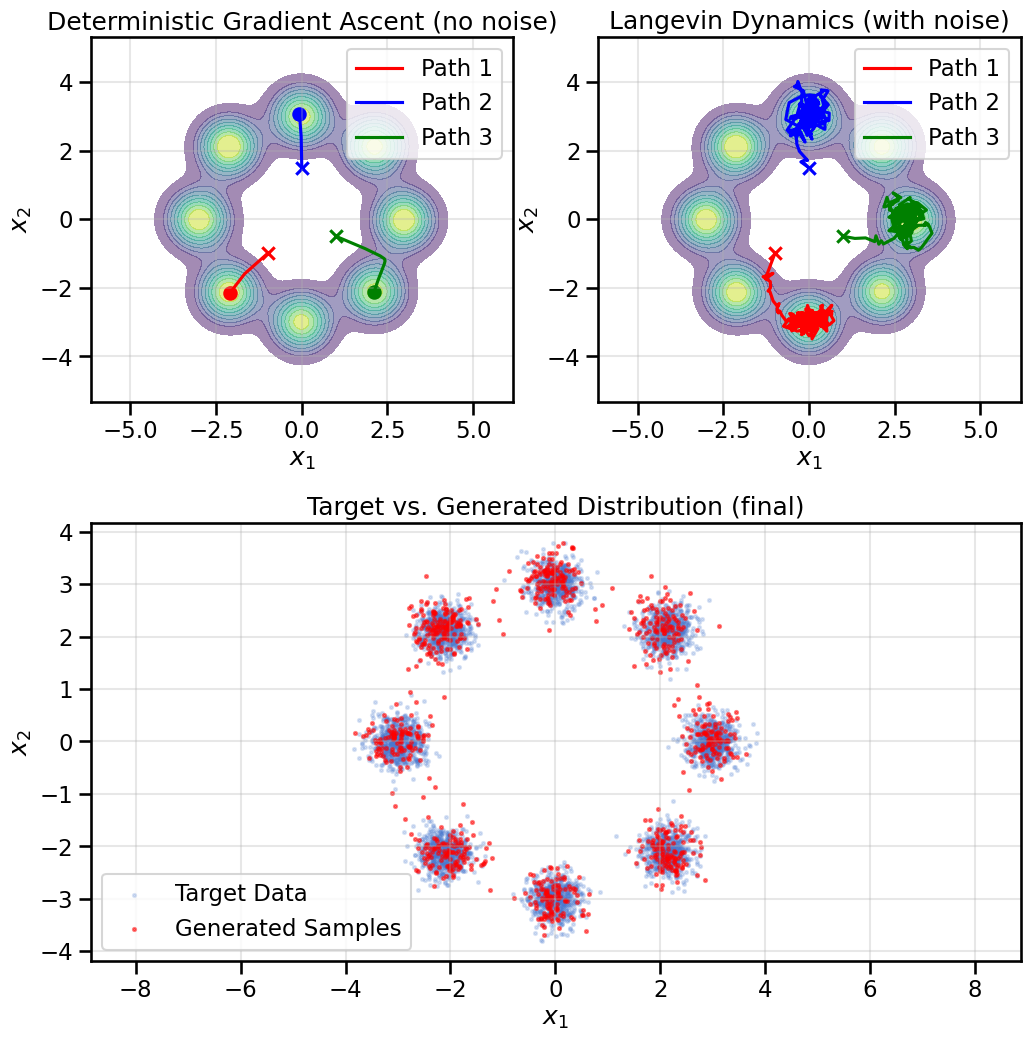

In [6]:
# Plot comparison with an additional row showing final distribution across full width
fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1.2], hspace=0.3, wspace=0.2)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[1, :])  # span both columns for a larger final distribution plot

colors = ['red', 'blue', 'green']

# Left: deterministic ascent
ax0.set_title('Deterministic Gradient Ascent (no noise)')
sns.kdeplot(x=data[:, 0], y=data[:, 1], cmap='viridis', fill=True, alpha=0.5, ax=ax0)
for i in range(det_traj.shape[1]):
    ax0.plot(det_traj[:, i, 0], det_traj[:, i, 1], color=colors[i], label=f'Path {i+1}')
    ax0.scatter(det_traj[0, i, 0], det_traj[0, i, 1], marker='x', color=colors[i], s=80)
    ax0.scatter(det_traj[-1, i, 0], det_traj[-1, i, 1], marker='o', color=colors[i], s=80)
ax0.axis('equal')
ax0.grid(True, alpha=0.3)
ax0.legend()
ax0.set_xlabel('$x_1$')
ax0.set_ylabel('$x_2$')

# Right: Langevin dynamics
ax1.set_title('Langevin Dynamics (with noise)')
sns.kdeplot(x=data[:, 0], y=data[:, 1], cmap='viridis', fill=True, alpha=0.5, ax=ax1)
for i in range(lang_traj.shape[1]):
    ax1.plot(lang_traj[:, i, 0], lang_traj[:, i, 1], color=colors[i], label=f'Path {i+1}')
    ax1.scatter(lang_traj[0, i, 0], lang_traj[0, i, 1], marker='x', color=colors[i], s=80)
    ax1.scatter(lang_traj[-1, i, 0], lang_traj[-1, i, 1], marker='o', color=colors[i], s=80)
ax1.axis('equal')
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.set_xlabel('$x_1$')
ax1.set_ylabel('$x_2$')

# Bottom: Final distribution (full-width)
ax2.set_title('Target vs. Generated Distribution (final)')
ax2.scatter(data[:, 0], data[:, 1], s=5, alpha=0.2, label='Target Data')
ax2.scatter(generated_samples.cpu()[:, 0], generated_samples.cpu()[:, 1], s=5, alpha=0.5, color='red', label='Generated Samples')
ax2.set_xlabel('$x_1$')
ax2.set_ylabel('$x_2$')
ax2.axis('equal')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

## The Final Bridge to Diffusion Models

This works, but we have one big new problem: the distribution depends on noise level, which remains constant during both training and sampling. If we set $\sigma$ too high, the learned score will be too smooth and miss important details of the data distribution. If we set $\sigma$ too low, the score will be too noisy and hard to learn accurately. 

What if we allowed ourselves to change the noise level as a function of time during sampling? Perhaps we could start with a high noise level (large $\sigma$) to capture the broad structure of the data, and then gradually reduce the noise (small $\sigma$) to refine the samples such that they begin to resemble the true data distribution.

This is **exactly what a Diffusion Model is**: a time-conditional score model $s_\theta(x_t, t)$ that is trained via Denoising Score Matching at all noise levels $t$ simultaneously. This allows for a much more powerful and stable generative process, which we will explore in the next chapter.

## Summary and Next Steps

-   Score Matching provides a way to train a generative vector field without computing the expensive trace of the Jacobian required by CNFs.
-   The core idea is to learn the **score function** ($\nabla_x \log p(x)$), which points towards regions of high data density.
-   **Denoising Score Matching (DSM)** makes this practical by reframing the problem as a simple L2 regression: predicting the noise added to a data sample.
-   Once the score function is learned, **Langevin Dynamics** can be used to generate new data by iteratively following the score field and adding noise.
-   This framework directly leads to **Diffusion Models**, which use a time-conditional score network to reverse a gradual noising process.